<a href="https://colab.research.google.com/github/ndronen/econdata/blob/main/notebooks/Electricity_consumption_and_GDP_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports
import re
from collections import defaultdict
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
#@title Mount Google Drive for saving plots
DRIVE_PATH = "/content/gdrive"
NOTEBOOK_PATH = f"{DRIVE_PATH}/My Drive/Colab Notebooks"
drive.mount(DRIVE_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#@title Set Pandas options
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option('mode.chained_assignment', 'raise')

In [4]:
#@title Data access functions
GDP_COUNTRY_CODE = "Country Code"
GDP_COUNTRY_NAME = "Country Name"
ELECTRICITY_COUNTRY_CODE = "Country Code"
ELECTRICITY_COUNTRY_NAME = "Country Name"


def get_years_from_column_names(df):
    years = []
    for column in df.columns:
        if re.match(r"^\d\d\d\d$", column):
            years.append(column)
    return years
            

def get_gdp_country_codes(gdp_df):
    codes = gdp_df[GDP_COUNTRY_CODE]
    return codes


def get_electricity_country_codes(electricity_df):
    codes = electricity_df[ELECTRICITY_COUNTRY_CODE]
    return codes


def get_common_codes(gdp_codes, electricity_codes):
    common_codes = set(gdp_codes).intersection(electricity_codes)
    return common_codes


def get_common_code_subset(common_codes, df, code_column_name):
    mask = df[code_column_name].apply(lambda code: code in common_codes)
    df = df[mask]
    df = df.sort_values(code_column_name)
    return df


def join_dataframes(gdp_df, electricity_df):
    # Rename the year columns of the electricity data frame.
    years = get_years_from_column_names(electricity_df)
    year_kwhs = []
    for year in years:
        year_kwh = year + "kwh"
        electricity_df[year_kwh] = electricity_df[year]
        year_kwhs.append(year_kwh)
    electricity_df.drop(labels=years, axis=1, inplace=True)

    years = get_years_from_column_names(gdp_df)
    non_year_columns = [
        column for column in gdp_df.columns if column not in years
    ]
    gdp_df.reset_index(inplace=True)
    electricity_df.reset_index(inplace=True)
    joined_df = pd.concat((gdp_df, electricity_df[year_kwhs]), axis=1)
    return joined_df


def only_countries_with_gdp_in_year(df, year):
    has_gdp = ~df[year].isnull()
    return df[has_gdp]


def get_extreme_countries_by_region(df, sort_column, k=1, method='head'):
    if method == 'head':
        def _sort_values(grp):
            return grp.sort_values(sort_column).head(k)
    else:
        def _sort_values(grp):
            return grp.sort_values(sort_column).tail(k)

    extremes = []
    for region, grp in df.groupby("Region"):
        extremes.append(_sort_values(grp))
    df = pd.concat(extremes)
    return df

In [5]:
#@title Plotting functions

def plot_electricity_consumption_for_countries(
    df, countries, max_total_year=None, cmap=None
):
    years = np.array(get_years_from_column_names(df))
    if cmap is None:
        cmap = plt.get_cmap("tab10")

    fig, ax = plt.subplots(1, figsize=(12, 4))
    fig.patch.set_facecolor("gray")
    fig.patch.set_alpha(0.5)

    max_year = int(years[0])
    all_countries_by_year = defaultdict(list)

    for i, country in enumerate(countries):
        df_country = df[df[GDP_COUNTRY_NAME] == country]        
        recorded_years = ~df_country[years].isnull().values[0]
        if len(years[recorded_years]):
            x = [int(ry) for ry in years[recorded_years]]
            if max(x) > max_year:
                max_year = max(x)
            y = df_country[years].values[0][recorded_years]
            ax.plot(x, y, label=country, c=cmap(i))

            for year, value in zip(years[recorded_years], y):
                all_countries_by_year[int(year)].append(value)

    # Also plot the total electricity consumption per capita.
    total_x = np.array(sorted(all_countries_by_year.keys()))
    total_y = []
    for x in total_x:
        total_y.append(sum(all_countries_by_year[x]))
    total_y = np.array(total_y)

    if max_total_year is not None:
        max_total_year_mask = total_x <= max_total_year
        total_x = total_x[max_total_year_mask]
        total_y = total_y[max_total_year_mask]

    ax.plot(total_x, total_y, label='Total', c=cmap(i + 1))

    years = years.astype(int)
    ax.set_xticks(years)
    ax.set_xticklabels(ax.get_xticks(), rotation=75)
    ax.set_xlim((years[0], max_year + 1))
    ax.set_xlabel("Year")
    ax.set_ylabel("Electricity consumption (kWh) per capita")
    ax.grid()
    fig.tight_layout(pad=2)
    ax.legend()
    return fig, ax

In [6]:
#@title Load data
base_url = "https://raw.githubusercontent.com/ndronen/econdata/6ed22721163d512788510bdc57b688cc7cd0b80a/data/"
electricity_url = f"{base_url}/kwh-power-consumption-per-capita-world-bank.csv"
gdp_url = f"{base_url}/gdp-per-capita-of-countries-in-current-usd-world-bank.csv"
electricity_df = pd.read_csv(electricity_url)
gdp_df = pd.read_csv(gdp_url)

In [7]:
#@title Preprocess and join the GDP and electricity data.
gdp_country_codes = get_gdp_country_codes(gdp_df)
electricity_country_codes = get_electricity_country_codes(electricity_df)
common_codes = get_common_codes(gdp_country_codes, electricity_country_codes)
clean_gdp_df = get_common_code_subset(common_codes, gdp_df, GDP_COUNTRY_CODE)
clean_electricity_df = get_common_code_subset(common_codes, electricity_df, ELECTRICITY_COUNTRY_CODE)

@dataclass
class WorldBankData:
    """Container for World Bank data."""
    gdp: pd.DataFrame
    electricity: pd.DataFrame

world_bank_data = WorldBankData(clean_gdp_df, clean_electricity_df)

Text(0.5, 1.0, 'Electricity consumption (kWh) per capita of developed economies')

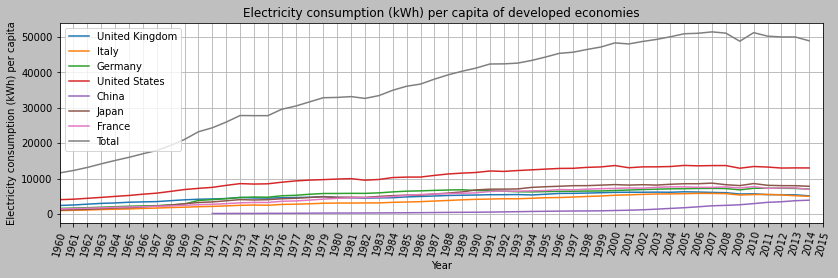

In [8]:
#@title Electricity consumption per capita for developed economies has peaked.
largest_by_gdp = {
    "United States",
    "China",
    "Japan",
    "Germany",
    "United Kingdom",
    "France",
    "Italy"
}

fig, ax = plot_electricity_consumption_for_countries(
    world_bank_data.electricity,
    largest_by_gdp
)
ax.set_title("Electricity consumption (kWh) per capita of developed economies")

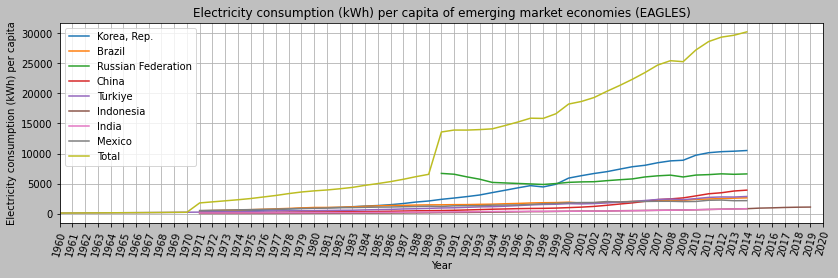

In [9]:
#@title Electricity consumption per capita of emerging market economics (EAGLEs) is growing.

# EAGLEs are defined here https://en.wikipedia.org/wiki/Emerging_market#BBVA_Research

emerging_market_eagles = {
    "Brazil",
    "China",
    "Korea, Rep.",
    "India",
    "Indonesia",
    "Mexico",
    "Russian Federation",
    "Turkiye"
}

fig, ax = plot_electricity_consumption_for_countries(
    world_bank_data.electricity,
    emerging_market_eagles,
    max_total_year=2014
)
ax.set_title("Electricity consumption (kWh) per capita of emerging market economies (EAGLES)");

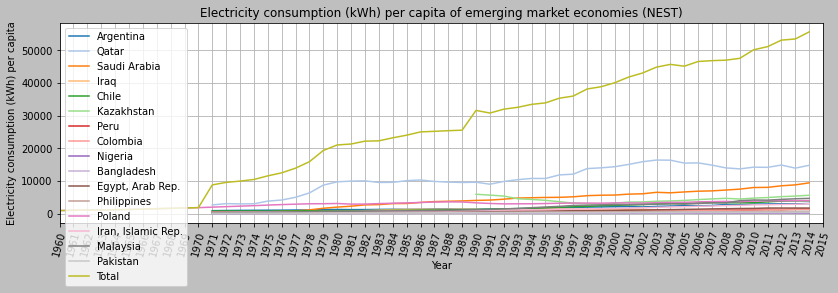

In [10]:
#@title Electricity consumption per capita of emerging market economics (NESTs) is growing.

# NESTs are defined here https://en.wikipedia.org/wiki/Emerging_market#BBVA_Research

emerging_market_nest = {
    "Argentina",
    "Bangladesh",
    "Chile",
    "Colombia",
    "Egypt, Arab Rep.",
    "Iran, Islamic Rep.",
    "Iraq",
    "Kazakhstan",
    "Malaysia",
    "Nigeria",
    "Pakistan",
    "Peru",
    "Philippines",
    "Poland",
    "Qatar",
    "Saudi Arabia",
}

fig, ax = plot_electricity_consumption_for_countries(
    world_bank_data.electricity,
    emerging_market_nest,
    max_total_year=2014,
    cmap=plt.get_cmap("tab20")
)
ax.set_title("Electricity consumption (kWh) per capita of emerging market economies (NEST)");